In [1]:
# Import Libraries
# Importing Numpy & Pandas for data processing & data wrangling
import numpy as np
import pandas as pd

# Importing  tools for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import evaluation metric libraries
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report

# Word Cloud library
from wordcloud import WordCloud, STOPWORDS

# Library used for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import model selection libraries
from sklearn.model_selection import train_test_split

# Library used for ML Model implementation
from sklearn.naive_bayes import MultinomialNB

# Importing the Pipeline class from scikit-learn
from sklearn.pipeline import Pipeline

# Library used for ignore warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Load Dataset from github repository
df = pd.read_csv("/content/spam.csv", encoding='ISO-8859-1')

In [3]:
# Dataset First Look
# View top 5 rows of the dataset
df.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
# Dataset Rows & Columns count
# Checking number of rows and columns of the dataset using shape
print("Number of rows are: ",df.shape[0])
print("Number of columns are: ",df.shape[1])

Number of rows are:  5572
Number of columns are:  5


In [6]:
# Dataset Info
# Checking information about the dataset using info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [7]:
# Data Wrangling
df.rename(columns={"v1": "Category", "v2": "Message"}, inplace=True)
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
df['Spam'] = df['Category'].apply(lambda x: 1 if x == 'spam' else 0)


In [8]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.Message, df.Spam, test_size=0.25, random_state=42)


In [11]:
# Function to Evaluate Model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    pred_prob_test = model.predict_proba(X_test)[:, 1]

    # Print evaluation metrics
    print("Classification Report (Test Set):")
    print(classification_report(y_test, y_pred_test))
    print("\nConfusion Matrix (Test Set):")
    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, pred_prob_test)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, pred_prob_test):.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

**Baseline Model: CountVectorizer + Default MultinomialNB**
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1202
           1       0.98      0.88      0.93       191

    accuracy                           0.98      1393
   macro avg       0.98      0.94      0.96      1393
weighted avg       0.98      0.98      0.98      1393


Confusion Matrix (Test Set):


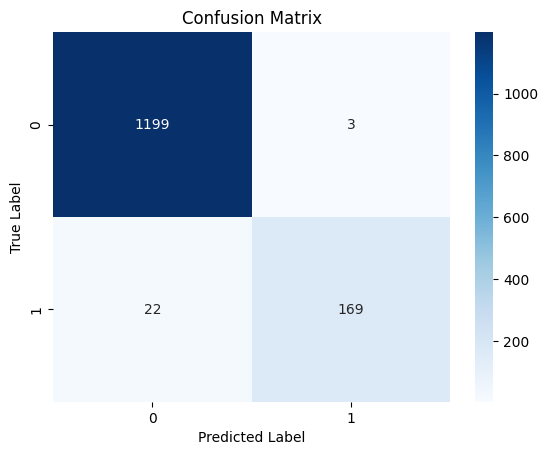

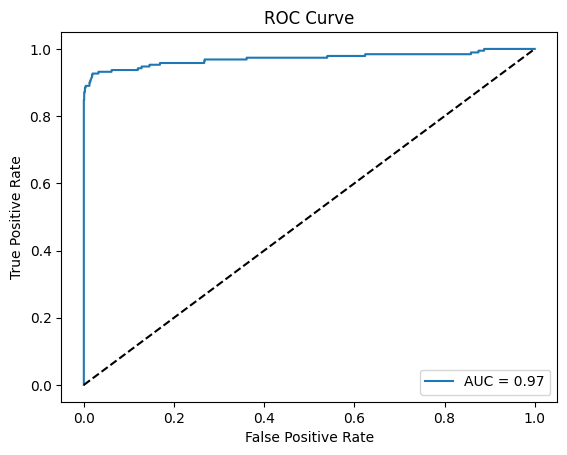

In [12]:
# 1: CountVectorizer with Default MultinomialNB
print("**Baseline Model: CountVectorizer + Default MultinomialNB**")
pipeline_count = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])
evaluate_model(pipeline_count, X_train, X_test, y_train, y_test)



**Baseline Model: TfidfVectorizer + Default MultinomialNB**
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1202
           1       1.00      0.71      0.83       191

    accuracy                           0.96      1393
   macro avg       0.98      0.85      0.90      1393
weighted avg       0.96      0.96      0.96      1393


Confusion Matrix (Test Set):


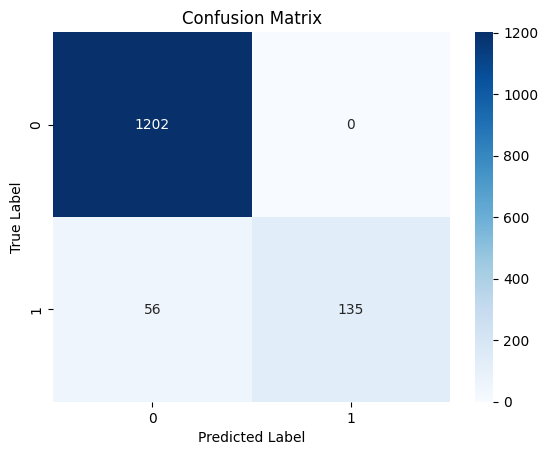

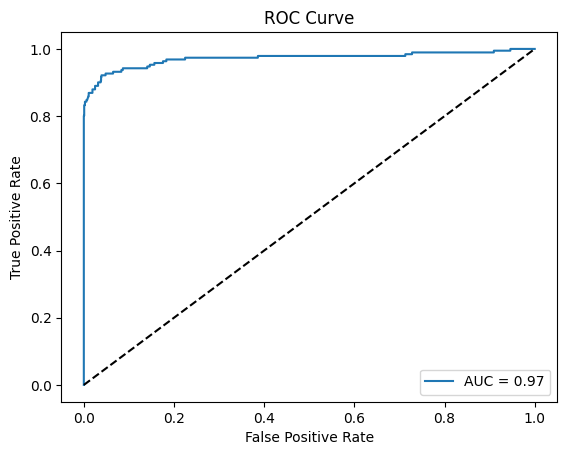

In [15]:
# 2: TfidfVectorizer with Default MultinomialNB
print("\n**Baseline Model: TfidfVectorizer + Default MultinomialNB**")
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
pipeline_tfidf = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])
evaluate_model(pipeline_tfidf, X_train, X_test, y_train, y_test)

In [20]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV # Importing GridSearchCV

pipeline_optimized = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])


In [17]:
# Define parameter grid
param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'vectorizer__max_df': [0.75, 1.0],
    'classifier__alpha': [0.1, 0.5, 1.0]
}


In [21]:
# Perform Grid Search
grid_search = GridSearchCV(pipeline_optimized, param_grid, cv=3, scoring='roc_auc', verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END classifier__alpha=0.1, vectorizer__max_df=0.75, vectorizer__ngram_range=(1, 1); total time=   0.1s
[CV] END classifier__alpha=0.1, vectorizer__max_df=0.75, vectorizer__ngram_range=(1, 1); total time=   0.1s
[CV] END classifier__alpha=0.1, vectorizer__max_df=0.75, vectorizer__ngram_range=(1, 1); total time=   0.1s
[CV] END classifier__alpha=0.1, vectorizer__max_df=0.75, vectorizer__ngram_range=(1, 2); total time=   0.2s
[CV] END classifier__alpha=0.1, vectorizer__max_df=0.75, vectorizer__ngram_range=(1, 2); total time=   0.2s
[CV] END classifier__alpha=0.1, vectorizer__max_df=0.75, vectorizer__ngram_range=(1, 2); total time=   0.2s
[CV] END classifier__alpha=0.1, vectorizer__max_df=1.0, vectorizer__ngram_range=(1, 1); total time=   0.1s
[CV] END classifier__alpha=0.1, vectorizer__max_df=1.0, vectorizer__ngram_range=(1, 1); total time=   0.1s
[CV] END classifier__alpha=0.1, vectorizer__max_df=1.0, vectorizer__ngram_ran

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier', MultinomialNB())]),
             param_grid={'classifier__alpha': [0.1, 0.5, 1.0],
                         'vectorizer__max_df': [0.75, 1.0],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)]},
             scoring='roc_auc', verbose=2)

In [22]:
# Best Parameters and Score
print("\nBest Parameters:", grid_search.best_params_)
print("Best Cross-Validation AUC Score:", grid_search.best_score_)


Best Parameters: {'classifier__alpha': 0.1, 'vectorizer__max_df': 0.75, 'vectorizer__ngram_range': (1, 1)}
Best Cross-Validation AUC Score: 0.9922835557835682


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1202
           1       0.99      0.86      0.92       191

    accuracy                           0.98      1393
   macro avg       0.99      0.93      0.95      1393
weighted avg       0.98      0.98      0.98      1393


Confusion Matrix (Test Set):


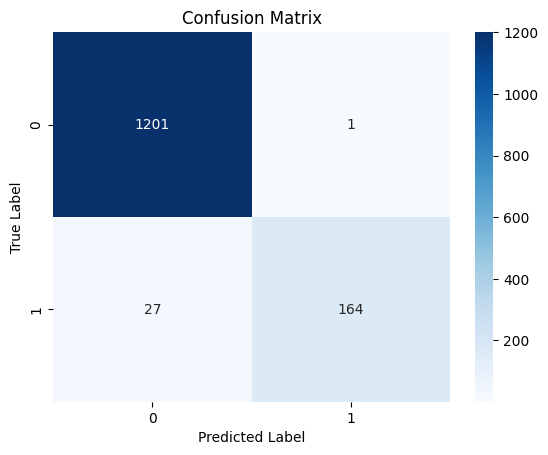

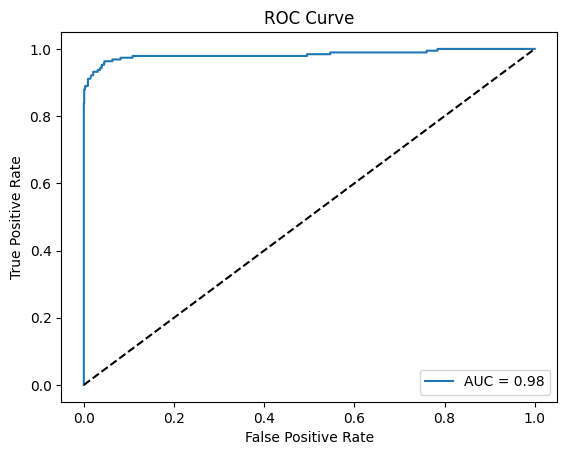

In [23]:
# Evaluate Best Model
best_model = grid_search.best_estimator_
evaluate_model(best_model, X_train, X_test, y_train, y_test)

ML Model: Multinomial Naive Bayes

In [24]:
# ML Model - 1 Implementation
# Create a machine learning pipeline using scikit-learn, combining text vectorization (CountVectorizer)
# and a Multinomial Naive Bayes classifier for email spam detection.
clf = Pipeline([
    ('vectorizer', CountVectorizer()),  # Step 1: Text data transformation
    ('nb', MultinomialNB())  # Step 2: Classification using Naive Bayes
])

# Model is trained (fit) and predicted in the evaluate model

Explain the ML Model used and it's performance using Evaluation metric Score Chart.

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1202
           1       0.98      0.88      0.93       191

    accuracy                           0.98      1393
   macro avg       0.98      0.94      0.96      1393
weighted avg       0.98      0.98      0.98      1393


Confusion Matrix (Test Set):


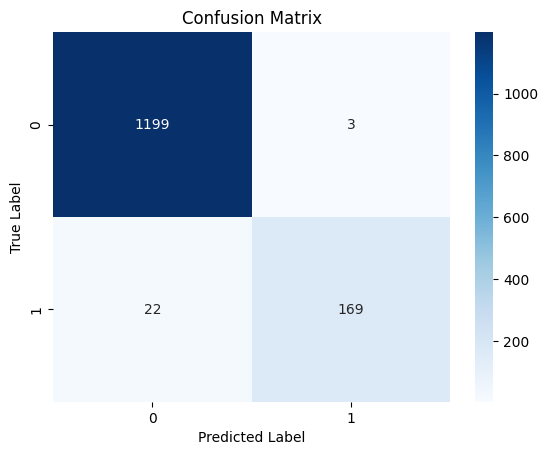

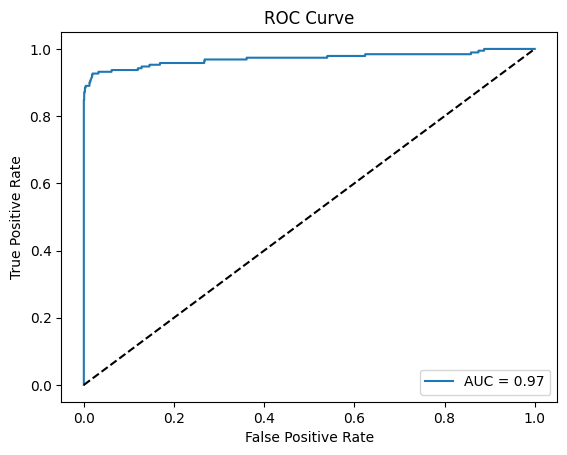

In [25]:
# Visualizing evaluation Metric Score chart
MultinomialNB_score = evaluate_model(clf, X_train, X_test, y_train, y_test)